In [54]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from biodatatools.utils.common import json_load
from mphelper import ProcessWrapPool
from scipy.stats import zscore
from adjustText import adjust_text
from openpyxl import load_workbook
import itertools
from biodata.delimited import DelimitedWriter
import matplotlib.lines as mlines
import sys
from pathlib import Path
import pybedtools

In [2]:
sys.path.append(str(Path.cwd().parent))
import utils

In [170]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [37]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/"
PROJECT_DIR_s2 = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_o2 = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# DE analysis (CRC lung vs. brain metastasis)

## Run DESeq2

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")

In [6]:
# Compare lung vs. brain metastasis from CRC

m_samples = ["Met3", "Met4", "Met7", "Met10"]
Counter([tuple(labels[s]) for s in m_samples])

Counter({('Large intestine', 'Lung'): 2, ('Large intestine', 'Brain'): 2})

In [116]:
# Get differentially expressed elements between T1D and normal T cells

results = [labels[s][1] for s in m_samples]
df = pd.DataFrame(results, index=m_samples, columns=["Condition"])
outputfile = f"{PROJECT_DIR_o}DE/CRC/samples.txt"
df.to_csv(outputfile, sep="\t")

In [7]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [9]:
# Keep elements found in these samples

outputfile = f"{PROJECT_DIR_o}DE/CRC/elements.bed"
es = {}
with DelimitedWriter(outputfile) as dw:
	for p, d in itertools.product(ps, ds):
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es[(p,d)] = set(df[df[m_samples].sum(axis=1) >= 1].index)
		for e in es[(p,d)]:
			dw.write(e.split("_"))

In [98]:
# Get raw counts

df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/raw_reads_all.txt", index_col=0)
df_filtered = df[m_samples].loc[[e for k in es for e in es[k]]]
outputfile = f"{PROJECT_DIR_o}DE/CRC/raw_reads.txt"
df_filtered.to_csv(outputfile, sep="\t")

In [ ]:
# Run DESeq2 analysis in Data_preprocessing/2-2.DESeq2.ipynb

In [12]:
p = "divergent"
d = "distal"
res = pd.read_table(f"{PROJECT_DIR_o}DE/CRC/DESeq2.txt")
res = res.dropna()
res = res.loc[[e for e in list(res.index) if e in es[(p,d)]]]
res.head(2)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
chr6_135266715_135266893,21.575151,-0.708655,1.171481,0.112805,0.398689
chr1_219924333_219924729,62.995481,4.133769,1.537754,0.000071,0.004077


In [82]:
# Lung is the ref level
# Up: higher signals in Brain
# Down: higher signals in Lung

padj_cutoff = 0.05
lfc_cutoff = 1
conditions = [
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] > lfc_cutoff),
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] < -lfc_cutoff),
]
ks = ["Down", "Up"]
res["Label"] = np.select(conditions, ks, default="Unchanged")
Counter(res["Label"])

Counter({'Unchanged': 13683, 'Down': 623, 'Up': 505})

## Heatmap

In [13]:
n_samples = list(pd.read_table(f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt", header=None)[0])
mn_samples = m_samples.copy()
for t in ["Large intestine", "Lung", "Brain"]:
	mn_samples.extend([s for s in n_samples if labels[s][1] == t])

In [17]:
# Use Z-score to highlight the tissue-specific expression blocks
# row: samples
# column: elements

DE_es = list(res[res["Label"]=="Down"].index) + list(res[res["Label"]=="Up"].index)
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
df_zscores = df_exp[mn_samples].loc[DE_es].apply(zscore, axis=1)

In [18]:
# Map the sample labels to corresponding colors

colors = []
for s in mn_samples:
	if s in m_samples:
		if labels[s][1] == "Lung":
			colors.append("#fb8072") 
		else:
			colors.append("#bc80bd") 
	else:
		colors.append(cdict[labels[s][1]]) 
color_vectors = pd.DataFrame(colors, index=mn_samples)
color_vectors.columns = [""]
color_vectors.head(2)

,
Met3,#fb8072
Met4,#fb8072


In [19]:
subtypes = ["Large intestine → Lung", "Large intestine → Brain", "Large intestine", "Lung", "Brain"]
palette = sns.color_palette(list(dict.fromkeys(colors)))

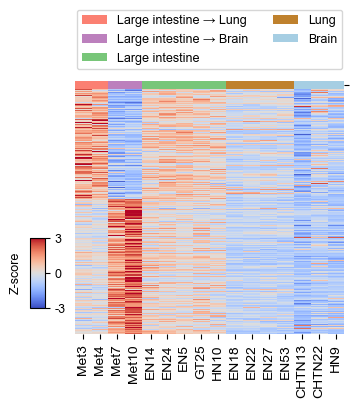

In [20]:
vlims = [-3,0,3]
g = sns.clustermap(data=df_zscores, cmap="coolwarm", 
				  xticklabels=True, yticklabels=False, 
				  row_cluster=False, col_cluster=False,
				  col_colors=color_vectors, figsize=(3,3.5),
				  vmin=vlims[0], vmax=vlims[-1],
				  dendrogram_ratio=(0,0.01)
				  )	
	
for label in subtypes:
	i = subtypes.index(label)
	g.ax_col_dendrogram.bar(0, 0, color=palette[i],
							label=label,
							linewidth=0)

g.ax_col_dendrogram.legend(title="", fontsize=sfontsize, ncol=2, bbox_to_anchor=(0.5,1.17), loc="upper center", bbox_transform=plt.gcf().transFigure)	

g.cax.set_visible(False)
cbar_ax = g.fig.add_axes([-0.1, 0.3, 0.05, 0.2])
cbar = plt.colorbar(g.ax_heatmap.collections[0], cax=cbar_ax)
cbar.ax.text(-0.9, 0.5, "Z-score", rotation=90,
			 fontsize=sfontsize, ha='center', va='center', transform=cbar.ax.transAxes)
cbar.set_ticks(vlims)
cbar.set_ticklabels([str(v) for v in vlims])
cbar.ax.tick_params(labelsize=sfontsize) 

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig10b.png", bbox_inches="tight", dpi=300, transparent=True)

# Motif enrichment

In [18]:
# Use all divergent distal elements found in these samples as background

outputfile = f"{PROJECT_DIR_o}homer/CRC/bg.bed"
utils.generate_homer_input([e for e in es[(p,d)]], outputfile)

In [124]:
for k in ks:
	outputfile = f"{PROJECT_DIR_o}homer/CRC/{k}.bed"
	es = list(res[res["Label"]==k].index)
	utils.generate_homer_input(es, outputfile)

In [23]:
pwpool = ProcessWrapPool(len(ks))

homer_dir = f"{PROJECT_DIR_s}homer/"
bg = f"{PROJECT_DIR_o}homer/CRC/bg.bed"
for k in ks:
	target = f"{PROJECT_DIR_o}homer/CRC/{k}.bed"
	outdir = f"{PROJECT_DIR_o}homer/CRC/{k}"
	pwpool.run(utils.run_homer, args=[homer_dir, target, bg, outdir])

In [44]:
len(pwpool.finished_tasks)

2

In [45]:
pwpool.close()

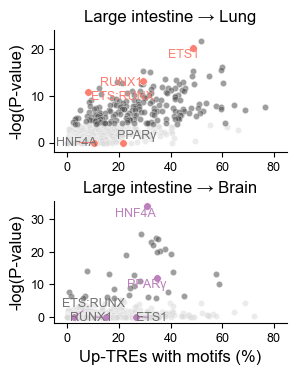

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(3,3.8))

alpha = 0.5
s = 20

for k in ks[::-1]:
	row = ks[::-1].index(k)
	# will change the folder name later
	inputfile = f"{PROJECT_DIR_o}homer/CRC/{k}/knownResults.txt"
	df = pd.read_table(inputfile)
	df["-logp"] = -df["Log P-value"]
	df["percent"] = df["% of Target Sequences with Motif"].str.replace('%', '', regex=False).astype(float)

	# all
	g = sns.scatterplot(data=df, x="percent", y="-logp", c="#d9d9d9", alpha=alpha, s=s, ax=ax[row])
	g.spines[["top", "right"]].set_visible(False)

	# significant ones
	df_sig = df[df["q-value (Benjamini)"]<0.05]
	sns.scatterplot(data=df_sig, x="percent", y="-logp", c="#525252", alpha=alpha, s=s, ax=ax[row])

	# Highlight a few motifs
	color = "#bc80bd" if k == "Up" else "#fb8072"
	keep = ["ETS1(ETS)/Jurkat-ETS1-ChIP-Seq(GSE17954)/Homer", 
			"RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer",
			"ETS:RUNX(ETS,Runt)/Jurkat-RUNX1-ChIP-Seq(GSE17954)/Homer",
			"HNF4a(NR),DR1/HepG2-HNF4a-ChIP-Seq(GSE25021)/Homer",
			"PPARE(NR),DR1/3T3L1-Pparg-ChIP-Seq(GSE13511)/Homer",
		   ]
	df_highlight = df[df["Motif Name"].isin(keep)].copy()
	sns.scatterplot(data=df_highlight, x="percent", y="-logp", c=color, s=30, ax=ax[row])
	
	df_highlight["Motif Name"] = df_highlight["Motif Name"].apply(lambda x: x.split('(')[0]).str.upper()
	texts = []
	cs = []
	for _, drow in df_highlight.iterrows():
		motif = drow["Motif Name"] if drow["Motif Name"] != "PPARE" else "PPARγ"
		texts.append((drow["percent"], drow["-logp"], motif))
		if drow["q-value (Benjamini)"] < 0.05:
			cs.append(color)
		else:
			cs.append("#737373")		
	texts = [ax[row].text(texts[idx][0], texts[idx][1], texts[idx][2], ha='center', va='center', c=cs[idx], fontsize=sfontsize) for idx in range(len(texts))]
	adjust_text(texts, arrowprops=dict(arrowstyle='-', color=color, lw=0.8), ax=ax[row])
	
	if row == 1:
		g.set_xlabel("Up-TREs with motifs (%)", fontsize=bfontsize)
	else:
		g.set_xlabel("")
	g.set_xlim([-5,85])
	
	g.set_ylabel("-log(P-value)", fontsize=bfontsize)
	if row == 0:
		g.set_ylim([-2,24])
		g.set_yticks([0,10,20])

	g.tick_params(labelsize=sfontsize)

	title = "Large intestine → Lung" if k == "Down" else "Large intestine → Brain"
	g.set_title(title, fontsize=bfontsize)

plt.subplots_adjust(hspace=0.4)
plt.savefig(f"{PROJECT_DIR_o}figures/Fig6e.pdf", bbox_inches="tight", transparent=True)

In [133]:
# Write the content of all motifs in "knownResults.html"

outputfile = f"{PROJECT_DIR_o}tables/SuppTable3.xlsx"
book = load_workbook(outputfile)
with pd.ExcelWriter(outputfile, engine='openpyxl', mode='a', if_sheet_exists='replace') as f:
	for k in ks:
		html = f"{PROJECT_DIR_o}homer/CRC/{k}/knownResults.html"
		df = pd.read_html(html, header=0)[0]
		columns_keep = [c for c in df.columns if c not in ["Motif", "Motif File", "SVG"]]
		df = df[columns_keep]
		df = df[~df["Rank"].astype(str).str.contains(r"\*", na=False)]
		k2 = "Lung" if k == "Down" else "Brain"
		df.to_excel(f, sheet_name=f"CRC Met-{k2}", index=False)

# Browser shots

In [38]:
gtf_file = f"{PROJECT_DIR_r}genomes/human/gencode.v37.annotation.gtf.gz"
gtf = pd.read_csv(
	    gtf_file,
	    sep="\t",
	    comment="#",
	    header=None,
	    names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
	)

In [48]:
cdict2 = {}
for t in subtypes:
	cdict2[t] = palette[subtypes.index(t)]

In [46]:
# Select the suitable transcripts

regions = {
		   "ETS1": ("ENST00000319397.6", "chr11_128522200_128522700"),
		   "HNF4A": ("ENST00000316099.9", "chr20_44400925_44401442")
		  }

In [27]:
rpm_bws = {}
for s in mn_samples:
	rpm_bws[s] = [f"{PROJECT_DIR_o2}rpm/{s}_{k}_rpm.bw" for k in ["pl", "mn"]]

In [25]:
samples_dict = {}
for s in mn_samples:
	samples_dict[s] = [s]

In [49]:
df_rpm = {}
for gene in regions:
	df_rpm[gene] = utils.get_reads(regions[gene][1], rpm_bws, samples_dict)

In [29]:
strands = ["fwd", "rev"]
strand_colors = ["red", "blue"]

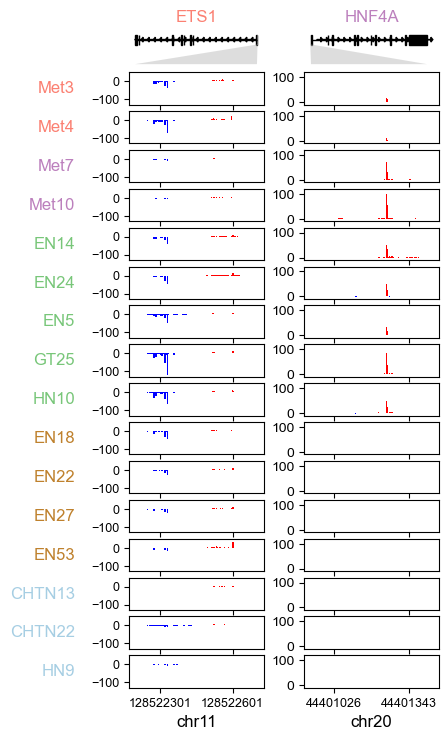

In [50]:
ylims = {"ETS1": [-130,50],
		 "HNF4A": [-10,120]
		}

fig, axes = plt.subplots(len(samples_dict)+1, 2, figsize=(4,8.5), gridspec_kw={"wspace": 0.3, "hspace": 0.2})
for gene in regions:
	col = list(regions).index(gene)

	# Gene position
	axes[0,col].axis("off")
	chrom, start, end = regions[gene][1].split("_")
	start, end = int(start)+100, int(end)-100
	color = "#fb8072" if gene == "ETS1" else "#bc80bd"
	utils.gene_representation(gene, regions[gene][0], gtf, axes[0,col], start, end, bfontsize, color)
	
	for s in samples_dict:
		row = list(samples_dict).index(s)+1
		ax = axes[row, col]
		for k in strands:
			df = df_rpm[gene][(df_rpm[gene]["type"]==s) & (df_rpm[gene]["orientation"]==k)]
			ax.bar(list(df["position"]), list(df["rpm"]), color=strand_colors[strands.index(k)], align='center', width=5)

		ax.ticklabel_format(useOffset=False, style='plain')
		ax.set_xticks([start, end])		
		if row == len(samples_dict):
			ax.set_xlabel(chrom, fontsize=bfontsize)
			ax.set_xticklabels([start+1, end+1], fontsize=sfontsize)
		else:
			ax.set_xticklabels([])

		color = "#fb8072" if gene == "ETS1" else "#bc80bd"
		if row == 0:
			ax.set_title(gene, fontsize=bfontsize, c=color)
			
		if col == 0:
			if s in groups["metastatic_cancer"]:
				subtype = f"Large intestine → {labels[s][1]}"
			else:
				subtype = labels[s][1]
			ax.set_ylabel(s, rotation=0, ha='right', va="center",
					  fontsize=bfontsize, c=cdict2[subtype])
			ax.tick_params(axis="y", labelsize=sfontsize)
			ax.yaxis.set_label_coords(-0.4, 0.5)
		else:
			ax.set_ylabel("")
	
		if ylims[gene]:
			ax.set_ylim(ylims[gene])
			
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig10c.png", bbox_inches='tight', dpi=300)

# Functional enrichment of gene sets

## Get target genes

In [52]:
# Expressed genes: genes with proximal elements (at least in one sample within the same group) as a proxy

d = "proximal"
for k in ks:
	samples2 = [s for s in m_samples if labels[s][1]=="Brain"] if k == "Up" else [s for s in m_samples if labels[s][1]=="Lung"]
	es = set()
	for p in ps:
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es |= set(df[df[samples2].sum(axis=1) >= 1].index)
	outputfile = f"{PROJECT_DIR_o}DE/CRC/{k}_{d}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in es:
			dw.write(e.split("_"))

In [55]:
# Assign proximal elements to genes

expressed_genes = defaultdict(set)
b1 = pybedtools.BedTool(f"{PROJECT_DIR_s2}ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed")
for k in ks:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/CRC/{k}_{d}.bed").sort()
	overlap = b2.intersect(b1, wao=True)
	# Keep the record with the largest overlap
	mapping = {}
	for i in overlap:
		if int(i.fields[-1]) > 0:
			e = ("_".join(i.fields[:3]))
			if e not in mapping:
				# gene, overlap length
				mapping[e] = (i.fields[6], int(i.fields[-1]))
			elif int(i.fields[-1]) > mapping[e][1]:
				mapping[e] = (i.fields[6], int(i.fields[-1]))
	expressed_genes[k] = set([mapping[e][0] for e in mapping])

In [57]:
# Get genomic coordinates of expressed genes

df = pd.read_table(f"{PROJECT_DIR_s2}ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed", header=None)
bg_genes = defaultdict(set)
for k in ks:
	bg_genes[k] = [g for g in df[3] if g in expressed_genes[k]]
	df2 = df[df[3].isin(bg_genes[k])]
	outputfile = f"{PROJECT_DIR_o}DE/CRC/expressed_genes_{k}.bed"
	df2.to_csv(outputfile, header=None, index=False, sep="\t")
	print(k, len(bg_genes[k]))

Up 10726
Down 11962


In [58]:
# Assign elements to the closest expressed genes

b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/CRC/elements.bed").sort()
for k in ks:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/CRC/expressed_genes_{k}.bed").sort()
	closest = b1.closest(b2)
	closest.saveas(f"{PROJECT_DIR_o}DE/CRC/closest_genes_{k}.bed")

In [59]:
e2g_closest = defaultdict(dict)
for k in ks:
	df = pd.read_table(f"{PROJECT_DIR_o}DE/CRC/closest_genes_{k}.bed", header=None)
	for _, row in df.iterrows():
		e = "_".join([row[0], str(row[1]), str(row[2])])
		gene = row[6]
		e2g_closest[k][e] = gene

## Pathway enrichment

In [60]:
# Closest genes for DE elements

genes = defaultdict(set)
for k in ks:
	es = list(res[res["Label"]==k].index)
	for e in es:
		genes[k].add(e2g_closest[k][e])
	print(k, len(genes[k]))

Up 483
Down 422


In [63]:
gmt = f"{PROJECT_DIR_d2}GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt"
df_merge = utils.run_enrichr(ks, gmt, genes, bg_genes)

2025-09-20 01:24:18,501 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt
2025-09-20 01:24:18,628 [INFO] Run: c5.go.bp.v2024.1.Hs.symbols.gmt 
2025-09-20 01:24:18,630 [INFO] ['EMILIN2', 'CANT1', 'SDC1', 'PLXNB2']
2025-09-20 01:24:18,631 [INFO] ['ANKRD36', 'CDKN3', 'KIAA1683', 'PLCD3']
2025-09-20 01:24:19,871 [INFO] Done.
2025-09-20 01:24:19,902 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt
2025-09-20 01:24:19,982 [INFO] Run: c5.go.bp.v2024.1.Hs.symbols.gmt 
2025-09-20 01:24:19,985 [INFO] ['SQSTM1', 'PITPNA', 'ZSWIM6', 'OPA1']
2025-09-20 01:24:19,986 [INFO] ['HIST1H3H', 'ANKRD36', 'CDKN3', 'BEX2']
2025-09-20 01:24:21,227 [INFO] Done.


In [71]:
# Lung

list(df_merge[df_merge["Group"]=="Down"].sort_values(by="-log10(padj)", ascending=False)["Term"])[:15]

['GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION',
 'GOBP_T_CELL_ACTIVATION',
 'GOBP_T_CELL_DIFFERENTIATION',
 'GOBP_REGULATION_OF_CELL_ACTIVATION',
 'GOBP_POSITIVE_REGULATION_OF_CELL_ADHESION',
 'GOBP_REGULATION_OF_CELL_ADHESION',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CELL_ADHESION',
 'GOBP_LYMPHOCYTE_ACTIVATION',
 'GOBP_REGULATION_OF_CELL_CELL_ADHESION',
 'GOBP_CELL_ACTIVATION',
 'GOBP_HEMOPOIESIS',
 'GOBP_CELL_ADHESION',
 'GOBP_REGULATION_OF_T_CELL_ACTIVATION',
 'GOBP_LYMPHOCYTE_DIFFERENTIATION',
 'GOBP_LEUKOCYTE_CELL_CELL_ADHESION']

In [70]:
# Brain

list(df_merge[df_merge["Group"]=="Up"].sort_values(by="-log10(padj)", ascending=False)["Term"])[:15]

['GOBP_INTRACELLULAR_SIGNALING_CASSETTE',
 'GOBP_CELL_MOTILITY',
 'GOBP_IMPORT_INTO_CELL',
 'GOBP_AMEBOIDAL_TYPE_CELL_MIGRATION',
 'GOBP_RESPONSE_TO_WOUNDING',
 'GOBP_LOCOMOTION',
 'GOBP_REGULATION_OF_LOCOMOTION',
 'GOBP_WOUND_HEALING',
 'GOBP_ACTOMYOSIN_STRUCTURE_ORGANIZATION',
 'GOBP_POSITIVE_REGULATION_OF_RESPONSE_TO_WOUNDING',
 'GOBP_REGULATION_OF_CELL_POPULATION_PROLIFERATION',
 'GOBP_NEUROGENESIS',
 'GOBP_RESPONSE_TO_ZINC_ION_STARVATION',
 'GOBP_MAPK_CASCADE',
 'GOBP_MUSCLE_CELL_PROLIFERATION']

In [72]:
selected_terms = ['GOBP_CELL_ADHESION',
				  'GOBP_CELL_MOTILITY',
				  'GOBP_T_CELL_ACTIVATION',
				  'GOBP_T_CELL_DIFFERENTIATION',
				  'GOBP_WOUND_HEALING',
				  'GOBP_ACTOMYOSIN_STRUCTURE_ORGANIZATION'
				  ]

In [73]:
def format_term(t):
    phrase = " ".join(t.split("_")[1:]).capitalize()
    return phrase

In [111]:
order = [format_term(term) for term in selected_terms][::-1]
df_top = df_merge[df_merge["Term"].isin(selected_terms)].copy()
df_top["Term"] = df_top["Term"].map(format_term)
df_top["Term"] = pd.Categorical(df_top["Term"], categories=order, ordered=True)
df_top.head(2)

,Group,Term,Gene ratio,Gene count,Adjusted P-value,-log10(padj)
442,Up,Cell motility,0.081878,916.0,0.000272,3.565272
4156,Up,Wound healing,0.115226,243.0,0.002332,2.632282


In [ ]:
vlims=[0,0.1,0.2]
fig, axes = plt.subplots(1, 2, figsize=(2.8, 2.2))
for ax, k in zip(axes, ks):
	title = "Lung" if k == "Down" else "Brain"
	color = "#fb8072" if k == "Down" else "#bc80bd"
	ax.set_title(title, fontsize=bfontsize, c=color)
	ax.margins(y=0.2)
	g = sns.scatterplot(
	    data=df_top[df_top["Group"]==k],
	    x="-log10(padj)",
	    y="Term",
	    size="Gene count",
		hue="Gene ratio",
		palette="viridis",
		hue_norm=(vlims[0], vlims[-1]),
		legend='brief',
		ax=ax
		)
	
	handles, labs = ax.get_legend_handles_labels()
	g.legend([], [], frameon=False)
	if ks.index(k) == 1:
		g.set_yticklabels([])
		size_handles_labels = [(h, l) for h, l in zip(handles, labs) if l.strip().isdigit()]
		size_handles, size_labels = zip(*size_handles_labels)
		g.legend(size_handles, size_labels, title="Gene count", title_fontsize=sfontsize, fontsize=sfontsize, loc="upper left", bbox_to_anchor=(1.1, 1.05))

		
		norm = plt.Normalize(vlims[0], vlims[-1])
		sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
		cbar_ax = fig.add_axes([1,0,0.03,0.2])
		cbar = plt.colorbar(sm, cax=cbar_ax)
		cbar.set_label("Gene ratio", fontsize=sfontsize)
		cbar.set_ticks(vlims)
		cbar.set_ticklabels([str(v) for v in vlims])
		cbar.ax.tick_params(labelsize=sfontsize)

	g.axvline(x=-np.log10(0.05), ls="--", c="grey")
	g.set_ylim([-0.5, 5.5])
	g.set_ylabel("")
	for label in ax.get_yticklabels():
		text = label.get_text()
		if text in order[:2]:
			label.set_color("#bc80bd")
		elif text in order[2:4]:
			label.set_color("#fb8072")
		else:
			label.set_color("black")
		label.set_fontsize(bfontsize)

	g.set_xlim([-2, 7])
	g.set_xlabel("-log$_{10}$FDR", fontsize=bfontsize)
	g.tick_params(axis="x", labelsize=sfontsize)

fig.text(0.3, 1.05, "Large intestine to:", fontsize=bfontsize)
g.plot([-1.2, 1], [1.16, 1.16], transform=g.transAxes, c="black", clip_on=False, lw=lw)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig10d.pdf", bbox_inches="tight", transparent=True)